### Sanity Check - Behavioural data 

# Setup

In [51]:
import pandas as pd
import glob
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import ttest_1samp
from scipy.stats import t

# Load in data

In [38]:
#Load in data with data path
data_path = "/work/MEG_data/workshop_data/behavioural_logs/"
all_files = glob.glob(os.path.join(data_path, "*.csv"))

df_list = []

for f in all_files:
    # The key part: read CSV and use the *first column* as data, not as index
    df = pd.read_csv(f, index_col=False)
    
    # If the first column is unnamed, rename it to 'subject'
    if df.columns[0].startswith("Unnamed"):
        df.columns = ["subject"] + list(df.columns[1:])
    
    df_list.append(df)

# Combine all files into one big dataframe
data = pd.concat(df_list, ignore_index=True)

print(f"✅ Loaded {len(all_files)} files with {data.shape[0]} total rows.")
data.head()

✅ Loaded 8 files with 3200 total rows.


,subject,trial_number,staircase_number,fixation_duration_ms,target_duration_ms,target_type,target_contrast,mask_duration_ms,objective_response,objective_response_time_ms,subjective_response,subjective_response_time_ms
0,169,0,0,716.666667,33.333333,stimulus_1,0.400000,33.333333,stimulus_1,2.149918,1,2.160107
1,169,1,0,700.000000,33.333333,stimulus_1,0.250988,33.333333,stimulus_1,3.338549,1,1.488952
2,169,2,0,566.666667,33.333333,stimulus_0,0.153029,33.333333,stimulus_1,1.027541,1,0.921889
3,169,3,0,733.333333,33.333333,stimulus_0,0.286338,33.333333,stimulus_1,2.111574,1,1.767445
4,169,4,0,575.000000,33.333333,stimulus_0,0.374182,33.333333,stimulus_0,1.269429,2,2.939059


## Create new column with accuracy 

Based on 'target_type' and 'objective_response'

1 = correct response

0 = incorrect response

In [39]:
data["accuracy"] = (data["target_type"] == data["objective_response"]).astype(int)

In [40]:
data[["target_type", "objective_response", "accuracy"]].head(10)

,target_type,objective_response,accuracy
0,stimulus_1,stimulus_1,1
1,stimulus_1,stimulus_1,1
2,stimulus_0,stimulus_1,0
3,stimulus_0,stimulus_1,0
4,stimulus_0,stimulus_0,1
5,stimulus_1,stimulus_1,1
6,stimulus_0,stimulus_0,1
7,stimulus_1,stimulus_1,1
8,stimulus_1,stimulus_1,1
9,stimulus_0,stimulus_0,1


## Check if objective response matches subjective reponse

In [41]:
acc_by_pas = data.groupby("subjective_response")["accuracy"].mean()
print(acc_by_pas)

subjective_response
1    0.546791
2    0.783838
3    0.910686
4    0.967647
Name: accuracy, dtype: float64


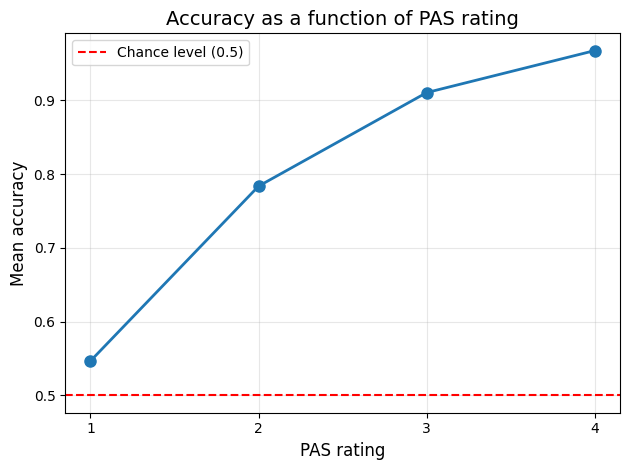

In [48]:
# Plot mean accuracy by PAS
plt.plot(acc_by_pas.index, acc_by_pas.values, marker="o", linewidth=2, markersize=8)

# Add chance level
plt.axhline(0.5, color="red", linestyle="--", label="Chance level (0.5)")

# Labels and title
plt.xlabel("PAS rating", fontsize=12)
plt.ylabel("Mean accuracy", fontsize=12)
plt.title("Accuracy as a function of PAS rating", fontsize=14)

# Only show PAS 1–4 on x-axis
plt.xticks([1, 2, 3, 4])

# Make grid and legend nicer
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [46]:

#Check statistical significance
corr, pval = spearmanr(data["subjective_response"], data["accuracy"])
print(f"Spearman correlation: r = {corr:.3f}, p = {pval:.4f}")


Spearman correlation: r = 0.329, p = 0.0000


Participants’ subjective experience correlates positively with their objective performance.
When they felt more certain (higher PAS), they were actually more likely to be correct.

In [47]:
#Check if PAS1 is different from chance

pas1 = data.loc[data["subjective_response"] == 1, "accuracy"]
t_stat, p_val = ttest_1samp(pas1, 0.5)
print(f"PAS=1 vs chance (0.5): t={t_stat:.3f}, p={p_val:.4f}")


PAS=1 vs chance (0.5): t=2.569, p=0.0104


Even when participants reported “no experience” (PAS=1), they still performed slightly above chance --> suggesting there may be some unconscious perceptual sensitivity (a small amount of implicit awareness).

### Plot with chance and CI

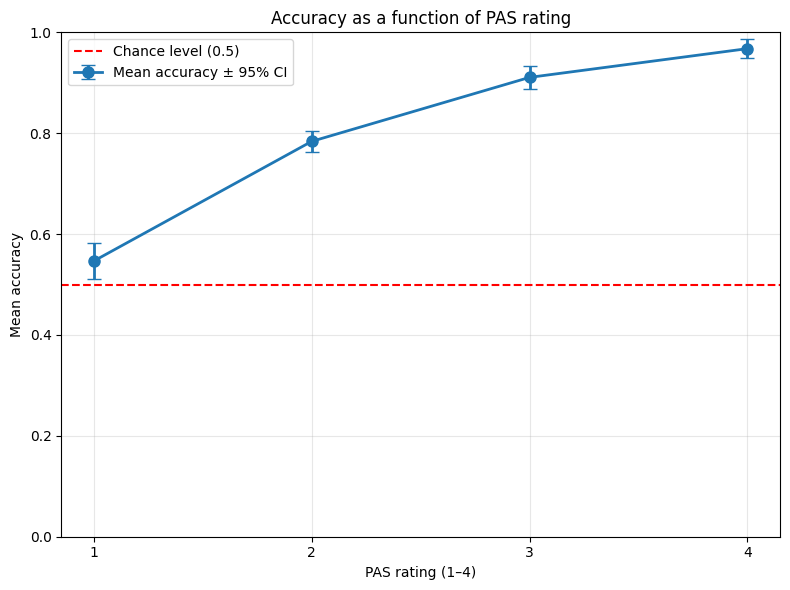

In [53]:
# Compute mean, SD, and standard error of accuracy for each PAS level
acc_summary = data.groupby("subjective_response")["accuracy"].agg(["mean", "count", "std"])
acc_summary["sem"] = acc_summary["std"] / np.sqrt(acc_summary["count"])

# Optional: 95% confidence interval
acc_summary["ci95"] = acc_summary["sem"] * t.ppf(0.975, acc_summary["count"] - 1)

# Plot mean ± 95% CI
plt.figure(figsize=(8, 6))
plt.errorbar(
    acc_summary.index,
    acc_summary["mean"],
    yerr=acc_summary["ci95"],
    fmt="o-",
    capsize=5,
    linewidth=2,
    markersize=8,
    label="Mean accuracy ± 95% CI"
)

# Add chance line and formatting
plt.axhline(0.5, color="red", linestyle="--", label="Chance level (0.5)")
plt.xticks([1, 2, 3, 4])
plt.ylim(0, 1)  # <- ensures y-axis runs from 0 to 1
plt.xlabel("PAS rating (1–4)")
plt.ylabel("Mean accuracy")
plt.title("Accuracy as a function of PAS rating")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
